# MorphSpotClean demo

In [1]:
import sys, os

sys.path.insert(0, "/Users/kaestner/git/scripts/python/")
sys.path.insert(0, "/Users/kaestner/git/install/lib/")

if 'LD_LIBRARY_PATH' not in os.environ:
    os.environ['LD_LIBRARY_PATH'] = '/Users/kaestner/git/install/lib'

In [2]:
os.environ['LD_LIBRARY_PATH'] = '/Users/kaestner/git/install/lib'

In [3]:
os.environ['LD_LIBRARY_PATH']

'/Users/kaestner/git/install/lib'

## Load needed modules

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import amglib.readers as io
import amglib.imageutils as amg

import imgalg 

In [8]:
import importlib

importlib.reload(imgalg)
importlib.reload(io)
importlib.reload(amg)

<module 'amglib.imageutils' from '/home/kaestner/git/install/lib/amglib/imageutils.py'>

## Get some data
### Load reference images

In [9]:
ob = io.readImages('../../../data/projections/ob_{0:04d}.tif',1,5,averageStack=True).mean(axis=0)
dc = io.readImages('../../../data/projections/dc_{0:04d}.tif',1,5,averageStack=True).mean(axis=0)

100%|██████████| 4/4 [00:00<00:00, 200.57it/s]


### Load projection stack

In [10]:
proj = io.readImages('../../../data/projections/wood_{0:04d}.tif',1,626) # This takes a while

100%|██████████| 625/625 [00:01<00:00, 601.74it/s]


### Normalize projections

In [11]:
norm = imgalg.NormalizeImage(True) # True for use logarithm
norm.setReferences(ob,dc)
norm.process(proj)

## Spot cleaning
MorphSpotClean is module that processes the data in-place. This means that the result will be stored in the input image. If you want to compare the processed image to the original, you need to make a copy of the image. 
Let's first create a cleaner instance.

In [12]:
msc = imgalg.MorphSpotClean()

### The detection image
MorphSpotClean supports two main algorithms and each has the options to locate bright, dark or all outliers in the image. The method is chosen with the enum ```imgalg.MorphDetect``` that can take the following values:
- MorphDetectDarkSpots
- MorphDetectBrightSpots
- MorphDetectAllSpots
- MorphDetectHoles (legacy)
- MorphDetectPeaks (legacy)
- MorphDetectBoth  (legacy)

The method ```setCleanMethod``` is use to select type of detection image.

In [13]:
msc.setCleanMethod(detectionMethod=imgalg.MorphDetectAllSpots, cleanMethod=imgalg.MorphCleanReplace);

Mostly, it is not necessary to look at the detection image but here we will compute it for a single image.

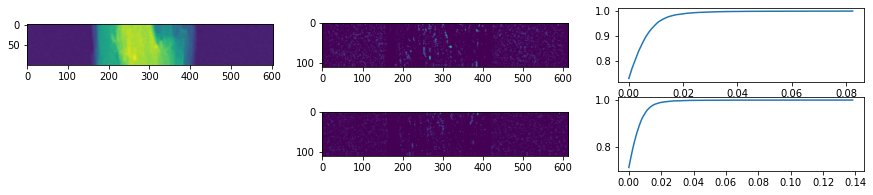

In [18]:
strip= proj[1,500:600,:].astype('float32')
dh=msc.detectionImage(strip,True)

fig, ax = plt.subplots(2,3,figsize=(15,3))
ax=ax.ravel()
ax[0].imshow(np.squeeze(strip))
ax[1].imshow(dh["dark"])
hhist,hbins=np.histogram(dh["dark"].ravel(), bins=500)
ax[2].plot(hbins[:-1],np.cumsum(hhist)/hhist.sum())

ax[3].axis('off')
ax[4].imshow(dh["bright"])
hhist,hbins=np.histogram(dh["bright"].ravel(), bins=500)
ax[5].plot(hbins[:-1],np.cumsum(hhist)/hhist.sum())

In this particular case, it seems that there are not very many outliers in the image. Therefore, it is reasonable to use a fraction close to 1.0 left untouched by the cleaning.

### Clean the image

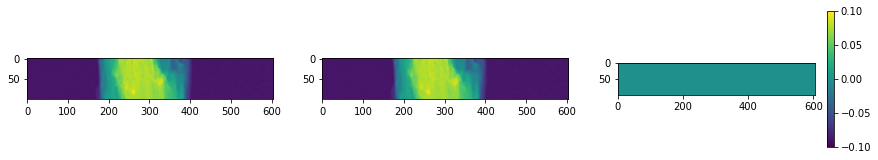

In [27]:
strip= proj[:,500:600,:].copy()
orig = proj[:,500:600,:]
msc.useThreading(True)
msc.process(strip,th=[0.9999, 0.9999],sigma=[0.01, 0.01])

fig, ax = plt.subplots(1,3,figsize=(15,5))
idx=10
ax[0].imshow(orig[idx])
ax[1].imshow(strip[idx])
im=ax[2].imshow(strip[idx]-orig[idx])
fig.colorbar(im,ax=ax[2],shrink=0.5)

#### Threading
In this exmaple we had threading active for the processing. This speeds up the processing to some extent. 
```msc.useThreading(True)``` turns on threaded processing. Default is currently ```False```.